In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import re
import seaborn as sns


In [97]:
base_file = "result/20251119_020409_base.json"
ours_file = "result/20251119_023633_ours_gpu4.json"

# base_file = "result/20251119_012141_base.json"
# ours_file = "result/20251119_015020_ours_gpu5.json"

with open(base_file, "r") as f:
    data = json.load(f)

nthreads = data["nthreads"]
cpu_kernel_path = data["cpu_kernel_path"]
gpu_kernel_config = data["gpu_kernel_config"]
npu_kernel_path = data["npu_kernel_path"]
cpu_matmul_shape = re.search(r"\d+x\d+x\d+", cpu_kernel_path).group()
gpu_matmul_shape = "x".join(gpu_kernel_config.split(",")[1:])
npu_matmul_shape = re.search(r"(\d+x\d+x\d+)", npu_kernel_path).group()
print("CPU matmul shape:", cpu_matmul_shape)
print("GPU matmul shape:", gpu_matmul_shape)
print("NPU matmul shape:", npu_matmul_shape)

cpu_latency, gpu_latency, cpu_latency_standalone, gpu_latency_standalone = data["cpu_latency"], data["gpu_latency"], data["cpu_latency_standalone"], data["gpu_latency_standalone"]
npu_stat, npu_stat_standalone = data["npu_stat"], data["npu_stat_standalone"]

with open(ours_file, "r") as f:
    data_ours = json.load(f)

cpu_latency_ours, gpu_latency_ours = data_ours["cpu_latency"], data_ours["gpu_latency"]
npu_stat_ours = data_ours["npu_stat"]


CPU matmul shape: 1x8192x8192
GPU matmul shape: 257x4096x4096
NPU matmul shape: 257x4096x4096


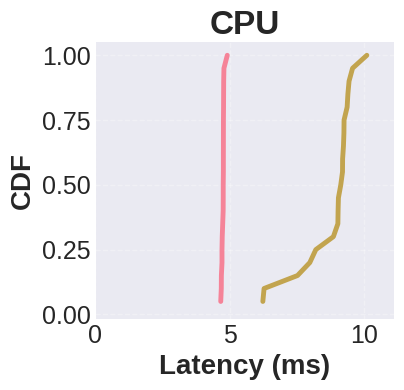

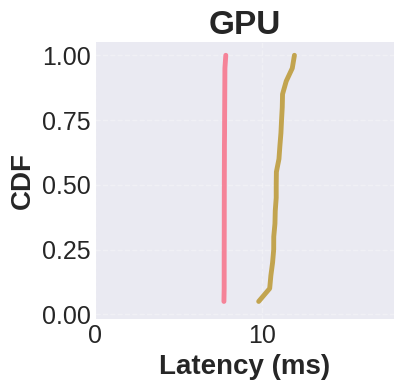

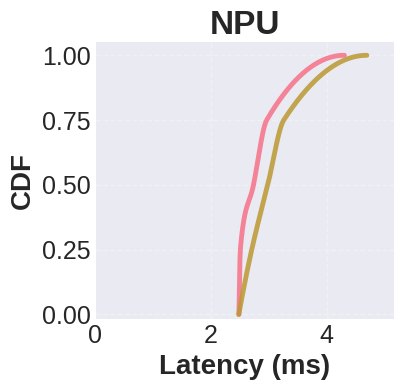

In [102]:
from scipy.interpolate import PchipInterpolator

def draw_cdf(latency_dict, title):
    # latency_dict: {"standalone": [...], "contended": [...], "ours": [...], ...}
    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    
    colors = sns.color_palette("husl", len(latency_dict))
    
    for (label, latencies), color in zip(latency_dict.items(), colors):
        sorted_latencies = np.sort(latencies)
        cdf = np.arange(1, len(sorted_latencies) + 1) / len(sorted_latencies)
        ax.plot(sorted_latencies, cdf, label=label.capitalize(), linewidth=3.5, alpha=0.85)
    
    ax.set_title(f"{title}", fontsize=24, fontweight='bold')
    ax.set_xlabel("Latency (ms)", fontsize=20, fontweight='bold')
    ax.set_ylabel("CDF", fontsize=20, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=18)
    # ax.set_xlim(0, max(max(latencies) for latencies in latency_dict.values()) * (1.1 if "CPU" in title else 1.5))
    ax.set_xlim(0, max(latency_dict["baseline"]) * (1.1 if "CPU" in title else 1.5))
    ax.set_ylim(-0.02, 1.05)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=1.0)
    # ax.legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    plt.tight_layout()
    plt.show()

def draw_pseudo_cdf(stat_dict, title):
    # stat_dict: {"standalone": {...}, "contended": {...}, "ours": {...}, ...}
    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    
    colors = sns.color_palette("husl", len(stat_dict))
    
    for (label, stats), color in zip(stat_dict.items(), colors):
        # Create points: 0%, 25%, 50%, 75%, 100%
        # Approximate using min, mean-std, mean, mean+std, max
        std = stats.get('std', (stats['max'] - stats['min']) / 4)
        
        # Ensure all x values are strictly increasing
        x_vals = [
            stats['min'],
            stats['mean'] - std/2,
            stats['mean'],
            stats['mean'] + std/2,
            stats['max']
        ]
        
        # Force strict monotonicity by adding small epsilon if needed
        x = []
        for i, val in enumerate(x_vals):
            if i == 0:
                x.append(val)
            else:
                x.append(max(val, x[-1] + 1e-6))
        
        y = [0, 0.25, 0.5, 0.75, 1.0]
        
        # Use PCHIP (Piecewise Cubic Hermite Interpolating Polynomial)
        # This guarantees monotonicity
        x_smooth = np.linspace(x[0], x[-1], 200)
        pchip = PchipInterpolator(x, y)
        y_smooth = pchip(x_smooth)
        
        # Plot smooth curve only (no markers)
        ax.plot(x_smooth, y_smooth, label=label.capitalize(), linewidth=3.5, alpha=0.85)
    
    ax.set_title(f"{title}", fontsize=24, fontweight='bold')
    ax.set_xlabel("Latency (ms)", fontsize=20, fontweight='bold')
    ax.set_ylabel("CDF", fontsize=20, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xlim(0, max(stats['max'] for stats in stat_dict.values()) * 1.1)
    ax.set_ylim(-0.02, 1.05)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=1.0)
    # ax.legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    plt.tight_layout()
    plt.show()

draw_cdf(
    {
        "standalone": cpu_latency_standalone,
        "baseline": cpu_latency,
        # "ours": cpu_latency_ours
    },
    # f"CPU ({cpu_matmul_shape})"
    f"CPU"
)
draw_cdf(
    {
        "standalone": gpu_latency_standalone,
        "baseline": gpu_latency,
        # "ours": gpu_latency_ours
    },
    # f"GPU ({gpu_matmul_shape})"
    f"GPU"
)
draw_pseudo_cdf(
    {
        "standalone": npu_stat_standalone,
        "baseline": npu_stat,
        # "ours": npu_stat_ours
    },
    # f"NPU ({npu_matmul_shape})"
    f"NPU"
)
